# MO444 - Machine Learning - 1s2021
## Projeto 1: aprendizado não supervisionado

**Grupo:** Elisa Dell Arriva (135551) e Felipe Pereira (??????).
_________________________________________________________________________

# 1 Introdução
Os dois métodos implementados foram: k-means e DBSCAN.

blablabla


# 2 Datasets
blablabal


# 3 Algoritmos
Nesta seção, descrevemos os algoritmos implementados.
## 3.1 K-means

## 3.2 BDSCAN
O DBSCAN (*Density-Based Spatial Clustering of Applications with Noise*) é um algoritmo de aprendizado não-supervisionado da classe dos algoritmos baseados em desidade. Ele cosegue identificar *clusters* de formatos arbitrários e, além disso, é capaz de detectar pontos que caracterizam ruído. 
Para explica o funcionamento do DBSCAN, precisamos de algumas definições.
Para o escopo dessa subseção, chamamos uma *sample* de *nó*. O DBSCAN requer dois parâmetros. O primeiro deles representa um raio de distância, que aqui chamamos de *epsilon*. 
A *vizinhança* de um nó X é definida como o conjunto dos nós que estão a no máximo uma distância *epsilon* de X. 
O segundo parâmetro, que aqui chamamos de *densidade*, determina o número mínimo de pontos que um *cluster* deve ter. Além disso, um nó é classificado como um dentre três tipos, descritos a seguir:
- **core**: se o tamanho de sua vizinhança é maior que o valor do parêmetro densidade;
- **border**: se ele não é core mas tem pelo menos um core em sua vizinhança;
- **noise**: se ele não é border nem core.

Dados um *dataset* e valores de *epsilon* e de densidade, o algoritmo funciona da seguinte maneira. Todos os nós começam marcados como "indefinidos". O algoritmo visita cada nó e, se o nó ainda não foi visitado, ou seja, ainda está marcado como "indefinido", então ele é processado. Seja X um nó que será processado. O algoritmo primeiramente encontra a vizinhança de X; se o tamanho de X é maior que a densidade, então X é classificado como *core* e aí inicia-se um novo cluster formado, a princípio, por X e sua vizinhança. Para expandir o cluster, o algoritmo analisa cada vizinho Y de X. Se a vizinhança de Y é maior que a densidade, então Y é classificado como *core* e sua vizinhança também deve ser analisada; se, por outro lado, a vizinhança de Y é menor que a densidade, então Y é classificado como *border* e sua vizinhança não é analisada. 
Agora, no caso em que a vizinhança de X é menor que a densidade, então X não inicia um novo *cluster* e é marcado como *noise* para que ele possa, possivelmente, ser abarcado por algum outro *cluster*.
Sejam **DS** um *dataset*, **EPS** o parâmetro de distândia e **D** o parâmetro de densidade. A seguir, mostramos um pseudo-código do algoritmo que implmentamos.

    DBSCAN(DS, EPS, D): 
    para cada NO em DS:
        se NO não foi visitado:
            encontre a vizinhança V de NO
            se o tamanho de V é maios que D:
                classifique NO como core
                inicie um cluster C a partir de NO
            senão:
                classifique NO como noise

Ao final da execução do algoritmo, temos cada nó associado a um *cluster* ou ao rótulo *noise*. Dessa forma, conseguimos definir quais são os *clusters* e quais são os ruídos. 

O desafio maior que o DBSCAN nos impôs foi o de ajustar seus parâmetros de entrada, especialmente pelo fato de serem dois deles. 
Para estimar um bom conjunto de parâmetros, nossa abordagem foi rodar o algoritmo com várias combinações diferentes, calcular o *silhouette score* para cada uma delas e, por fim, escolher a combinação que apresentou o melhor *score*.
Para definir o intervalo de valores a ser considerado para a densidade, partimos da ideia, comum na literatura, de considerar duas vezes a dimensão do *dataset*. Como precisávamos de um intervalo de valores, optamos por seguir nesse raciocíneo e, então, consideramos valores entre duas a cinco vezes a dimensão do *dataset*.
Para estimar o parâmetro de distância,as abordagens foram mais escassas. Então, optamos por considerar um intervalo grande de valores, de forma a garantir que distâncias curtas e longas estejam sendo consideradas.

<Uma forma de estimar o parâmetro de distância é verificar o grafo dos k vizinhos mais próximos para cada ponto do *dataset*. Tentamos imlementar essa ideia, mas não finalizamos. A ideia é, para cada ponto, calcular os k vizinhos mais próximos, ordená-los em ordem crescente e considerar a distância do k-ésimo. Após fazer isso para todos os pontos, desenhar um gráfico cujo eixo x seja os pontos e, o eixo y, a maior distância entre os k mais próximos daquele ponto. A ideia é que isso gere um grafo do tipo cotovelo que indica um bom valor para o parâmetro distância. Contudo, note que, para essa estratégia, preciamos do parâmetro k. Mas uma boa saída é considerar o k como sendo o valor da densidade desejada.> 


# 4 Código fonte
A seguir, colocamos todo o código fonte necessário para rodar os experimentos.

In [90]:
# Modules import
import random
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import queue

# Class of colors to use with the print funtion
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### Classes 

In [114]:
#Class that represents a sample
class Sample:
    def __init__(self, identifier, features):
        self.identifier = identifier #Number that identifies the sample
        self.features = features #Array of feature values of the sample
        self.cluster = None
        self.silhouette_a = None
        self.silhouette_b = None
        self.silhouette_score = None
        

#Class that represents a centroid
class Centroid:
    def __init__(self, identifier, features):
        self.identifier = identifier #Number that identifies the centroid
        self.features = features #Array of feature values of the centroid
        self.list_of_samples = [] #Array containing all the samples that are assigned to this centroid
        

#Class that represents a cluster
class Cluster:
    def __init__(self, identifier, list_of_samples):
        self.identifier = identifier #Number that identifies the cluster
        self.list_of_samples = list_of_samples #Array containing all the samples that are assigned to this cluster
        
        
#Class that represents a node for the DBSCAN method
class DBSCAN_node:
    def __init__(self, sample, label, cluster):
        self.sample = sample 
        self.label = label   # (undefined | noise | core | border)
        self.cluster = cluster # name of the cluster the node belongs to
        self.neighborhood = set() 

### Processamento do dataset, normalizações e métricas

In [112]:
#######################################################################################################
# Read the dataset from input file
def get_dataset(filename):
    dataset_file = open(filename,"r") #Get the input file
    dataset_file_lines = dataset_file.readlines() #Read all the lines of the input file
    dataset = [] #Array that will contain all samples objects
    
    for i in range(len(dataset_file_lines)): #For each line of the input file
        dataset_file_lines[i] = dataset_file_lines[i].split() #Split the line at the spaces
        features = list(map(float, dataset_file_lines[i])) #Get the features values list in float format
        new_sample = Sample(i+1, features) #Create new Sample object
        dataset.append(new_sample) #Append the new sample to the dataset
        
    return dataset

            
#######################################################################################################
# Divide the dataset into training and test sets
def divide_dataset(dataset, training_set_proportion, test_set_proportion):

    training_set_size = math.floor(training_set_proportion*len(dataset)) #Get the size of the training set
    #test_set_size = math.ceil(test_set_proportion*len(dataset)) #Get the size of the test set
    training_set = [] #Traning set array
    test_set = [] #Test set array

    for i in range(len(dataset)): #Partition the dataset into traning and test sets
        if i < training_set_size:
            training_set.append(dataset[i])
        else:
            test_set.append(dataset[i])
    return training_set, test_set

            
#######################################################################################################
# Function that calculates the euclidean distance between two samples
def get_distance(sample1, sample2, n_dimensions):
    sum = 0
    for i in range(n_dimensions):
        sum = sum + (sample1.features[i] - sample2.features[i])**2
    return math.sqrt(sum)

            
#######################################################################################################
# Function that applies the z-score method of normalization and standardization
def z_score_normalization(dataset, n_dimensions):
    for i in range(n_dimensions): #For each dimension i
        feature_values = [] #Create a list of all feature values of the i-th dimension
        for sample in dataset: #Fill the list
            feature_values.append(sample.features[i])
        feature_average = statistics.mean(feature_values) #Get the average value
        feature_stdev = statistics.stdev(feature_values) #Get the standard deviation value
        for sample in dataset: #For each sample, adjust its feature value of the i-th dimension
            sample.features[i] = (sample.features[i] - feature_average)/(feature_stdev) 
            
            
#######################################################################################################            
# Function that applies the min-max method of normalization
def min_max_normalization(dataset, n_dimensions):
    for i in range(n_dimensions): #For each dimension i
        max_value = -math.inf #Maximum value between the feature values of the i-th dimension
        min_value = math.inf #Minimum value between the feature values of the i-th dimension
        for sample in dataset: #Calculate max_value and min_value
            if sample.features[i] > max_value:
                max_value = sample.features[i]
            if sample.features[i] < min_value:
                min_value = sample.features[i]
        for sample in dataset: #For each sample, adjust its feature value of the i-th dimension
            sample.features[i] = (sample.features[i] - min_value)/(max_value - min_value)
            
#######################################################################################################            
# Fuction that calculates the silhouette score of a clusterization
def calculate_silhouette_score(clusters, n_dimensions):
    
    #This loop calculates the "a-score" of each sample
    for cluster in clusters:    #For each cluster C
        for sample in cluster.list_of_samples: #For each sample s in C
            sample.silhouette_a = 0 #Attribute that contains the "a-score" of s
            for sample_in_same_cluster in cluster.list_of_samples: #For each sample s' in C
                if(not(sample.identifier == sample_in_same_cluster.identifier)): #If s != s'
                    sample.silhouette_a += get_distance(sample, sample_in_same_cluster, n_dimensions) #Get the distance between s and s'
            if(len(cluster.list_of_samples) > 1): #If |C| > 1, then calculates the "a-score" of s
                sample.silhouette_a = float(sample.silhouette_a)/(len(cluster.list_of_samples)-1)
    
    #This loop calculates the "b-score" of each sample    
    for cluster in clusters: #For each cluster C
        for sample in cluster.list_of_samples: #For each sample s in C
            min_b = math.inf #Variable that contains the minimum possible "b-score" of s
            for other_cluster in clusters: #For each cluster C'
                if(not(other_cluster.identifier == cluster.identifier)): #If C != C'
                    current_b = 0 #Variable that contains "b-score" of s for C'
                    for sample_in_other_cluster in other_cluster.list_of_samples: #For each sample s' in C'
                        current_b += get_distance(sample, sample_in_other_cluster, n_dimensions) #Get the distance between s and s'
                    current_b = float(current_b)/len(other_cluster.list_of_samples) #Calculates the "b-score" of s related to C'
                    min_b = min(min_b, current_b) #Update the min_b, if it is the case
            sample.silhouette_b = min_b #Attribute that contains the "b-score" of s
            
    silhouette_sample_scores = [] #Array that will contain the score of each sample
    for cluster in clusters: #For each cluster C
        for sample in cluster.list_of_samples: #For each sample s in C
            sample.silhouette_score = (sample.silhouette_b - sample.silhouette_a)/max(sample.silhouette_a,sample.silhouette_b) #Calculates the score of s
            silhouette_sample_scores.append(sample.silhouette_score) #Add the score of s to the array of scores

    silhouette_score = statistics.mean(silhouette_sample_scores) #Calculate the final score of the clusterization, that is the average of all sample scores
    
    return silhouette_score      
            
#######################################################################################################
# Function that plots the average silhouette score for a fixed k, for each k in a given range

def plot_silhouette_avg_score_graph(dataset, n_dimensions, min_k, max_k, n_repetitions):
    
    points = [] #Points of the graph
    for k in range(min_k, max_k + 1): #For each value of k between min_k and max_k
        average = 0 #Variable that will contain the silhouette average value for the fixed k
        for i in range(n_repetitions): #Execute k-means n_repetitions times with same value of k
            clusters, centroids, sse = kmeans(dataset, k, n_dimensions) #Run the k-means algorithm
            silhouette_score = calculate_silhouette_score(clusters, n_dimensions) #Get the silhouette score of the clusterization
            average += silhouette_score
        average = float(average)/n_repetitions #Calculates the average score
        points.append([k,average]) #Add the point (k, silhouette average value)
    
    #Plot the graph
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])

    plt.xlabel("K", fontsize=15)
    plt.ylabel("Silhouette average score", fontsize=15)
    plt.xticks(list(range(min_k,max_k + 1)))    
    plt.grid(linestyle='--')
    plt.plot(x,y,'o-', color='green')
    plt.show()
    plt.close()
    
            
#######################################################################################################
# Function that plots the silhouette graph of a given clusterization
def plot_silhouette_graph(dataset, clusters, n_dimensions, k):
    
    #Calculate the silhouete score
    silhouette_score = calculate_silhouette_score(clusters, n_dimensions)
    
    #The following code plots the silhouette graph and it was adapted from 
    #https://medium.com/neuronio/unsupervised-learning-with-k-means-3eaa0666eebf
    
    silhouette_sample_scores = [] #Array that will contain the score of each sample
    for sample in dataset:
        silhouette_sample_scores.append(sample.silhouette_score) #Add the score of s to the array of scores
    min_silhouette_value = min(-0.1,min(silhouette_sample_scores))
    fig, (ax1) = plt.subplots(1)
    # The 1st subplot is the silhouette plot
    ax1.set_xlim([min_silhouette_value, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dataset) + (k + 1) * 10])
    # Compute the silhouette scores for each sample
    y_lower = 10
    for i,cluster in enumerate(clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = []
        for sample in cluster.list_of_samples:
            ith_cluster_silhouette_values.append(sample.silhouette_score)
        ith_cluster_silhouette_values.sort()
        size_cluster_i = len(ith_cluster_silhouette_values)
        y_upper = y_lower + size_cluster_i
        #color = plt.cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_score, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    x_ticks = []
    j = 1
    while j > min_silhouette_value:
        x_ticks.append(j)
        j = j - 0.1
    x_ticks.append(min_silhouette_value)
    ax1.set_xticks(x_ticks)
    print("Silhouette score for k = " + str(k) + ": " + str(silhouette_score))
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with " + str(k) + " clusters"))
    plt.show()
    plt.close()
    

## Funções utilizadas no K-Means

In [113]:
#Function that plots the elbow graph with repetitions for a each value of k
def plot_elbow_graph(dataset, n_dimensions, min_k, max_k, n_repetitions):
    
    elbow_points = [] #Points of the elbow graph
    for k in range (min_k, max_k + 1): #For each value of k between min_k and max_k
        average = 0 #Variable that will contain the SSE average value 
        for j in range(n_repetitions): #Execute k-means n_repetitions times with same value of k
            clusters, centroids, sse = kmeans(dataset, k, n_dimensions) #Run the k-means algorithm
            average += sse
        average = float(average)/n_repetitions 
        elbow_points.append([k,average]) #Add the point (k, SSE average value)

    #Plot the graph
    x = []
    y = []
    for point in elbow_points:
        x.append(point[0])
        y.append(point[1])

    plt.xlabel("K", fontsize=15)
    plt.ylabel("SSE", fontsize=15)
    plt.xticks(list(range(min_k,max_k + 1)))    
    plt.grid(linestyle='--')
    plt.plot(x,y,'o-')
    plt.show()
    plt.close()
    
    
#Function that plots a 2D graph of a clusterization
def plot_2D_clusters(clusters, centroids):
    for cluster in clusters:
        x = []
        y = []
        for sample in cluster.list_of_samples:
            x.append(sample.features[0])
            y.append(sample.features[1])
        plt.scatter(x, y)    
    x = []
    y = []
    for centroid in centroids: #If the centroids of the k-means were given in the input, plot them too
        x.append(centroid.features[0])
        y.append(centroid.features[1])
    plt.scatter(x, y, marker="x", color="black")
    plt.grid(linestyle='--')
    plt.show()
    plt.close()
    
##### K-means algorithm ######
#Function that assings each sample to a centroid
def set_clusters(dataset, centroids, dimensions):
    
    for centroid in centroids: #Initialize the list of samples of each centroid as an empty list
        centroid.list_of_samples = []
        
    for sample in dataset: #For each sample
        closest_centroid = None #Variable that will contain the closest centroid
        min_distance = math.inf
        for centroid in centroids: #Check the distance of all centroids and select the closest
            distance = get_distance(sample, centroid, dimensions)
            if distance < min_distance:
                min_distance = distance
                closest_centroid = centroid
        closest_centroid.list_of_samples.append(sample) #Add the sample to the list of samples of the closest centroid

        
#Function that calculates the Sum of the Squared Error
def get_sse(centroids, dimensions):
    sum = 0
    for centroid in centroids:
        for sample in centroid.list_of_samples:
            sum = sum + get_distance(centroid, sample, dimensions)**2
    return sum

#Function that updates the features values of each centroid
def update_centroids(centroids):
    for centroid in centroids: #For each centroid
        for i in range(len(centroid.features)): #For each feature of the centroid
            centroid.features[i] = 0  
            for j in range(len(centroid.list_of_samples)): #Collected the feature value of each sample assigned to the centroid
                centroid.features[i] += centroid.list_of_samples[j].features[i]
            if(len(centroid.list_of_samples) > 0): #If the cluster is not empty
                centroid.features[i] = centroid.features[i]/float(len(centroid.list_of_samples)) #Apply the average value

#Function that implements the k-means clusterization method
def kmeans(dataset, n_clusters, dimensions):
    
    drawed_samples = random.sample(dataset, n_clusters) #Draw n_clusters samples to be the initial centroids
    centroids = [] #Array of centroids
    for i in range(n_clusters): #Add the initial centroids
        new_centroid = Centroid(i+1, drawed_samples[i].features.copy())
        centroids.append(new_centroid)
    
    set_clusters(dataset, centroids, dimensions) #Set the initial clusters
    current_sse = get_sse(centroids, dimensions) #Calculate the inital error value
    sse_converged = False #Flag that indicates if the error value converged
    
    iteration = 1
    #print("Iteration #" + str(iteration))
    #plot_2D_clusters(centroids)
    
    while(not sse_converged): #Main loop of kmeans
        update_centroids(centroids) #Update the centroid features values
        set_clusters(dataset, centroids, dimensions) #Reset the clusters
        new_sse = get_sse(centroids, dimensions) #Get the new error value
        if new_sse < current_sse: #Check if the error value converged
            current_sse = new_sse
        else:
            sse_converged = True
        iteration += 1
        #print("Iteration #" + str(iteration))
        #plot_2D_clusters(centroids)
        
    clusters = []
    i = 1
    for centroid in centroids:
        new_cluster = Cluster(i, centroid.list_of_samples.copy())
        clusters.append(new_cluster)
        for sample in new_cluster.list_of_samples:
            sample.cluster = new_cluster
        i += 1
    
    return clusters, centroids, current_sse

#Function that extends a clusterization made by k-means to cluster the points from the test set
def extend_kmeans_clusterization(centroids, test_set, n_dimensions):
    set_clusters(test_set, centroids, n_dimensions)
    clusters = []
    i = 1
    for centroid in centroids:
        new_cluster = Cluster(i, centroid.list_of_samples.copy())
        clusters.append(new_cluster)
        for sample in new_cluster.list_of_samples:
            sample.cluster = new_cluster
        i += 1
    return clusters

## Funções utilizadas no DBSCAN

In [162]:
# Initialyze every node as undefined
def DBSCAN_initialization(dataset):
    DBSCAN_dataset = []
    for sample in dataset:
        new_node = DBSCAN_node(sample, "undefined", -1)
        DBSCAN_dataset.append(new_node)
    
    return DBSCAN_dataset


# Plot the clusterizartion represented by clusters
def DBSCAN_plot_2D_clusters(clusters):
    if len(clusters[0]) <= 0:
        del clusters[0]
    
    for c in clusters:
        x = []
        y = []
        for point in clusters[c]:
            x.append(point.sample.features[0])
            y.append(point.sample.features[1])
        plt.scatter(x, y)    
    plt.show()

    
# Find the neighborhood in a radius of <eps> of the node <point>
def DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, point):
    neighbors = []
    for n in dataset:
        if dist_func(n.sample, point.sample, dim) <= eps:
            neighbors.append(n)
    
    return set(neighbors)


# Expand the cluster starting inpoint <core>
def DBSCAN_find_cluster(dataset, dist_func, dim, eps, minPoints, core, n_cluster):
    cluster = []
    to_explore = deque()
    
    cluster.append(core)
    to_explore.append(core)
    
    # explore neighborhoods to expand the current cluster
    while len(to_explore) > 0:
        q = to_explore.popleft()
        q.neighborhood = DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, q)          
        
        # classify current point according to the size of its neighborhood
        if len(q.neighborhood) >= minPoints: # current point is core
            q.label = "core" 
            
            # mark each neighbor as part of the current cluster 
            for r in q.neighborhood:
                if r.label == "undefined" or r.label == "noise":
                    r.cluster = n_cluster
                    cluster.append(r)
                    
                    # classify current neighbor according to the size of its neighborhood
                    if len(DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, r)) >= minPoints:
                        r.label = "core"
                    else:
                        r.label = "border"
                    
                    # add neighbor to the queue (if it is not there yet), so its neioghborhood will be analyzed
                    if r not in to_explore:
                        to_explore.append(r)
                
        else: # current point is border  
            q.label = "border" 
    
    return cluster
    

# DBSCAN implementation
def DBSCAN(dataset, dist_func, dim, eps, minDensity):
    # obtain a dataset in the convenient format
    dataset = DBSCAN_initialization(dataset)
    
    # initialize auxiliary variables
    n_clusters = 0   # name of the clusters
    clusters = {}    # clusters obtained as the model
    clusters[0] = [] # list to gather all outliers in one cluster
    
    for point in dataset:
        if point.label == "undefined":
            point.neighborhood = DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, point)
            
            # check neighborhood of the current point
            if len(point.neighborhood) >= minDensity: # neighborhood is large enough, current point is a core point
                point.label = "core"
                
                # start a new cluster
                n_clusters += 1 
                point.cluster = n_clusters
                clusters[n_clusters] = DBSCAN_find_cluster(dataset, dist_func, dim, eps, minDensity, point, n_clusters)
            
            else: # neighborhood not large enough, then classify current point as noise so that it may later be joined in some cluster
                point.label = "noise"
                point.cluster = 0
                    
    # create one cluster for all the outliers
    for point in dataset:
        if point.label == "noise":
            clusters[0].append(point)

    return dataset, clusters  


# Find the distance of the k-nearest neighbors of <point>
def DBSCAN_get_nearest_distances(dataset, dist_func, dim, k, point):
    dist = []
    for q in dataset:
        dist.append(get_distance(q, point, dim))
    
    return sorted(dist)[:k]


# plot an elbow graph based on the k-nearest neighbors graph
def DBSCAN_plot_elbow_graph(dataset, func_dist, dim, k):
    k_neighbors = {p : [] for p in dataset}
    for p in dataset:
        k_neighbors[p] = DBSCAN_get_nearest_distances(dataset, func_dist, dim, k, p) 

    estimated_eps = [k_neighbors[p][k-1:] for p in training_set]
    estimated_eps = sorted(estimated_eps, reverse=True)

    # plot the elbow graph
    x = [i for i in range(len(estimated_eps))]
    y = estimated_eps
    plt.xlabel("index")
    plt.ylabel("distance")
    plt.plot(x, y, 'g-')    
    plt.show()


# adjust cluster format (from dictionary to list of object)
def DBSCAN_format_cluster_into_obj(clusters):
    clusters_list = []
    
    c_pairs = clusters.items()
    for p in c_pairs:
        sample_list = []
        for q in p[1]:
            q.sample.cluster = p[0]
            sample_list.append(q.sample)

        clusters_list.append( Cluster(p[0], sample_list) )
    
    if len(clusters_list[0].list_of_samples) <= 0:
        clusters_list = clusters_list[1:]
    
    return clusters_list
   
    
# plot the Silhouette coefficient graph for a set of clusters (model)
def DBSCAN_plot_silhouette_graph(dataset, clusters, dim, eps):
    clusters_list = DBSCAN_format_cluster_into_obj(clusters)
    plot_silhouette_graph(dataset, clusters_list, dim, eps)

    
# runs DBSCAN with a set of different configurations and returns the configuration that reaches the best silhoutte score
def DBSCAN_tune_parameters(dataset, dim, func_dist, densities, radii):
    Score = namedtuple("Score", ["density", "eps"])
    
    SS = {}
    for d in densities:
        # plot elbow
        for r in radii:
            s = Score(density=int(d), eps= r)
            model, clusters = DBSCAN(dataset, func_dist, dim, r, int(d))
            clusters_list = DBSCAN_format_cluster_into_obj(clusters)
            SS[s] = calculate_silhouette_score(clusters_list, dim)
        
    best_score = max(SS, key=SS.get)
    
    return best_score.density, best_score.eps, SS[best_score]

# 5 Experimentos

## 5.1 Parte 1


### K-means com dataset bidimensional

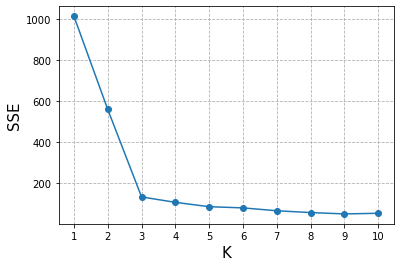

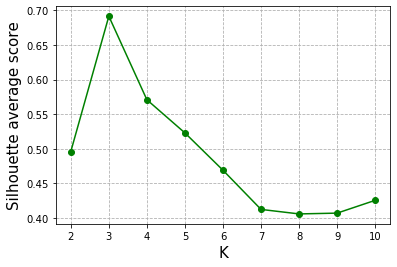

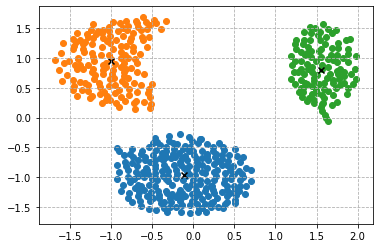

Silhouette score for k = 3: 0.6916289097903533


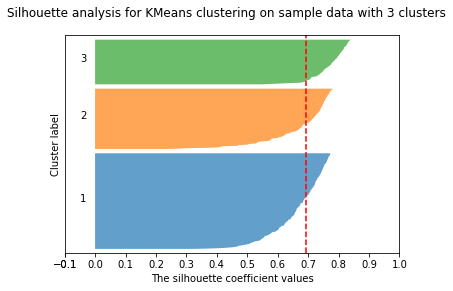

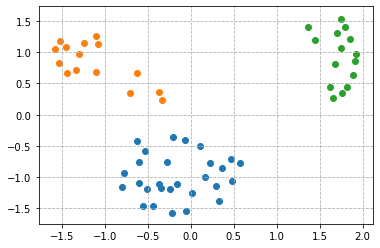

Silhouette score for k = 3: 0.6913289004455297


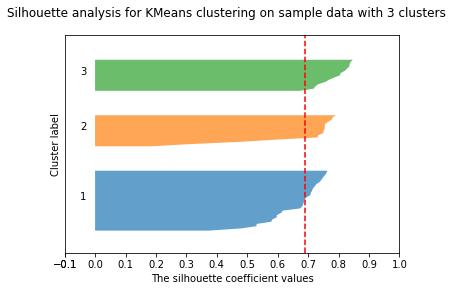

'\n#Testing K-means with 10-dimensional dataset\ndataset = get_dataset("trip_advisor.dat") #Build the dataset\nn_dimensions = 10\nrandom.shuffle(dataset) #Randomize the dataset array\n#min_max_normalization(dataset, n_dimensions) #Apply the min-max normalization\nz_score_normalization(dataset, n_dimensions) #Apply the z-score normalization\ntraining_set, test_set = divide_dataset(dataset, 0.9, 0.1) #Partition the dataset into training set and test set\nplot_elbow_graph(training_set, n_dimensions,1, 10, 5) #Plot elbow graph\nplot_silhouette_avg_score_graph(training_set,n_dimensions, 2, 10, 5) #Plot silhouette average score graph\n\nfor k in [2]:\n    clusters, centroids, sse = kmeans(training_set, k, n_dimensions)\n    plot_silhouette_graph(training_set, clusters, n_dimensions, k)\n    clusters_test_set = extend_kmeans_clusterization(centroids, test_set, n_dimensions)\n    plot_silhouette_graph(test_set, clusters_test_set, n_dimensions, k)\n'

In [36]:
#Experiment Part 1


#Testing K-means with 2-dimensional dataset

dataset = get_dataset("cluster.dat") #Build the dataset
n_dimensions = 2 #Set the number of dimensions
random.shuffle(dataset) #Randomize the dataset array
#min_max_normalization(dataset, n_dimensions) #Apply the min-max normalization
z_score_normalization(dataset, n_dimensions) #Apply the z-score normalization
training_set, test_set = divide_dataset(dataset, 0.9, 0.1) #Partition the dataset into training set and test set

plot_elbow_graph(training_set, n_dimensions,1, 10, 5) #Plot elbow graph
plot_silhouette_avg_score_graph(training_set,n_dimensions, 2, 10, 5) #Plot silhouette average score graph

for k in [3]:
    clusters, centroids, sse = kmeans(training_set, k, n_dimensions)
    plot_2D_clusters(clusters, centroids)
    plot_silhouette_graph(training_set, clusters, n_dimensions, k)
    clusters_test_set = extend_kmeans_clusterization(centroids, test_set, n_dimensions)
    plot_2D_clusters(clusters_test_set, [])
    plot_silhouette_graph(test_set, clusters_test_set, n_dimensions, k)

"""
#Testing K-means with 10-dimensional dataset
dataset = get_dataset("trip_advisor.dat") #Build the dataset
n_dimensions = 10
random.shuffle(dataset) #Randomize the dataset array
#min_max_normalization(dataset, n_dimensions) #Apply the min-max normalization
z_score_normalization(dataset, n_dimensions) #Apply the z-score normalization
training_set, test_set = divide_dataset(dataset, 0.9, 0.1) #Partition the dataset into training set and test set
plot_elbow_graph(training_set, n_dimensions,1, 10, 5) #Plot elbow graph
plot_silhouette_avg_score_graph(training_set,n_dimensions, 2, 10, 5) #Plot silhouette average score graph

for k in [2]:
    clusters, centroids, sse = kmeans(training_set, k, n_dimensions)
    plot_silhouette_graph(training_set, clusters, n_dimensions, k)
    clusters_test_set = extend_kmeans_clusterization(centroids, test_set, n_dimensions)
    plot_silhouette_graph(test_set, clusters_test_set, n_dimensions, k)
"""

### DBSCAN com dataset bidimensional

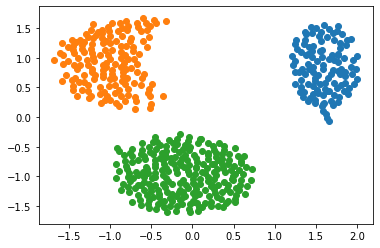

Silhouette score for k = 0.2357142857142857: 0.6917081572628668


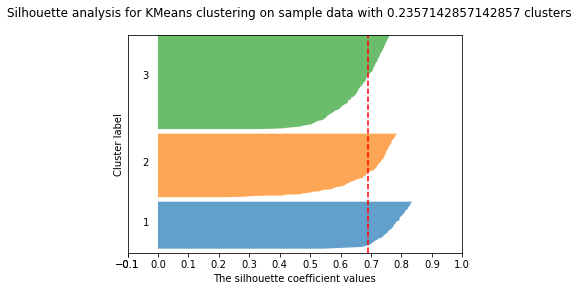

In [131]:
# Get dataset
ds_filepath = "cluster.dat"
ds = get_dataset(ds_filepath)

# Pre-process and divide the dataset into training and test sets
random.seed(135551) 
random.shuffle(ds) 
training_set, test_set = divide_dataset(ds, 0.9, 0.1)
z_score_normalization(training_set, 2)
z_score_normalization(test_set, 2)

# set hiper-parameters with the appropiate values
density_interval = np.linspace(2*dim, 5*dim, 5)
eps_interval = np.linspace(0.1, 2, 15)

# find best parameters according to silhouette score
best_d, best_e, best_ss = DBSCAN_tune_parameters(training_set, 2, get_distance, density_interval, eps_interval)

# runs DBSCAN using the appropiate values of epsilon (best_e) and density (best_d)
model, clusters = DBSCAN(training_set, get_distance, 2, best_e, best_d)

# plot the clusterization and the Silhouette coefficient
DBSCAN_plot_2D_clusters(clusters)
DBSCAN_plot_silhouette_graph(training_set, clusters, 2, best_e)

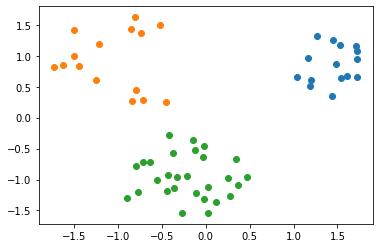

Silhouette score for k = 0.2357142857142857: 0.6817472790875616


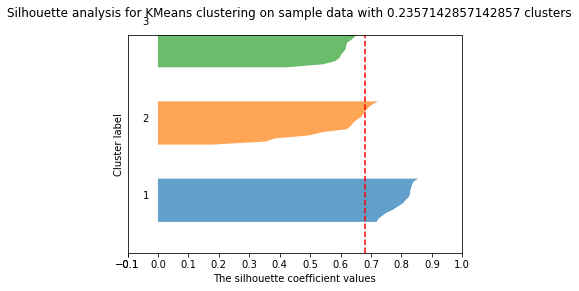

In [151]:
# initialization of data set and auxiliary variables
v_set = DBSCAN_initialization(test_set)
neighbors_count = {key: 0 for key in range(0,50)}
v_clusters = {key: [] for key in range(0,50)}

# get model generated by training the training set
model, clusters_2 = DBSCAN(training_set, get_distance, 2, best_e, best_d)  

# classify each point of the test set one of the clusters of the model
for v_point in v_set:
    # get neighborhood of the current point as if it was placed in the model set
    v_neighborhood = DBSCAN_find_neighborhood(model, get_distance, 2, best_e, v_point)
    
    # count the number of neighbors of each cluster
    for q in v_neighborhood:
        neighbors_count[q.cluster] += 1
    
    # set current point to the "most frequent" cluster in its "model neighborhood"
    v_point.cluster = max(neighbors_count, key=neighbors_count.get)
    
    # reset the counter of neighbors of each cluster
    neighbors_count = {key: 0 for key in neighbors_count}
    
# construct the dictionary with all clusters and plot the result
for p in v_set:
    v_clusters[p.cluster].append(p)

# plot the clusterization
DBSCAN_plot_2D_clusters(v_clusters)

# delete unused clusters
delete = [k for k,l in v_clusters.items() if len(l)==0]
for d in delete:
    del v_clusters[d]

# plot the silhouette coeffcient grapph
DBSCAN_plot_silhouette_graph(test_set, v_clusters, 2, best_e)

### DBSCAN com dataset 10-dimensional

d= 20 e= 0.1
Silhouette score for k = 0.1: 0.6392589118499178


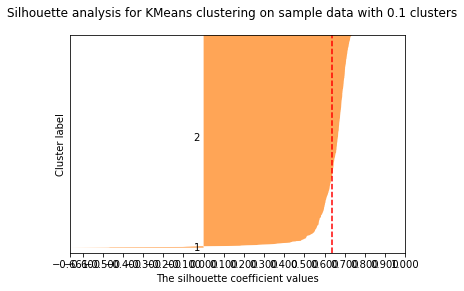

In [163]:
# Get dataset
ds_filepath = "trip_advisor.dat"
ds = get_dataset(ds_filepath)
dim = len(training_set[0].features) # get the number of features of the dataset

# Pre-process the dataset
random.seed(37154) 
random.shuffle(ds)
training_set, test_set = divide_dataset(ds, 0.9, 0.1) 
z_score_normalization(training_set, dim)
z_score_normalization(test_set, dim)

# set hiper-parameters with the appropiate values
density_interval = np.linspace(2*dim, 5*dim, 5)
eps_interval = np.linspace(0.1, 10)

# find best parameters according to silhouette score
best_d, best_e, best_ss = DBSCAN_tune_parameters(training_set, dim, get_distance, density_interval, eps_interval)
print("d=", best_d, "e=", best_e)
# runs DBSCAN using the appropiate values of epsilon (best_e) and density (best_d)
model, clusters = DBSCAN(training_set, get_distance, dim, 6, 20)

# plot the clusterization and the Silhouette coefficient
#DBSCAN_plot_2D_clusters(clusters)
if len(clusters[0]) <= 0:
    del clusters[0]

DBSCAN_plot_silhouette_graph(training_set, clusters, dim, best_e)

In [74]:
# initialization of data set and auxiliary variables
v_set = DBSCAN_initialization(test_set)
neighbors_count = {key: 0 for key in range(0,len(test_set))}
v_clusters = {key: [] for key in range(0,len(test_set))}

# run through each point of the test set so as to classify them
for v_point in v_set:
    # get neighborhood of the current point as if it was placed in the model set
    v_neighborhood = DBSCAN_find_neighborhood(model, get_distance, dim, best_e, v_point)
    
    # count the number of neighbors of each cluster
    for q in v_neighborhood:
        neighbors_count[q.cluster] += 1
    
    # set current point to the "most frequent" cluster in its "model neighborhood"
    v_point.cluster = max(neighbors_count, key=neighbors_count.get)
    
    # reset the counter of neighbors of each cluster
    neighbors_count = {key: 0 for key in neighbors_count}
    
# construct the dictionary with all clusters and plot the result
for p in v_set:
    v_clusters[p.cluster].append(p)
    
# delete unused clusters
delete = [k for k,l in v_clusters.items() if len(l)==0]
for d in delete:
    del v_clusters[d]

# plot the silhouette coeffcient grapph
DBSCAN_plot_silhouette_graph(test_set, v_clusters, dim, best_e)
    
print("teset set, number of clusters: ", len(v_clusters))


Fisrt approach: run DBSCAN for the test set with the most convenient configuration obtained from the training step.
test set, approach 1, number of clusters:  2

Second approach: assign to each point in the test set, the "most frequent cluster" in the neighborhood of the point when considered the training set.
training set, number of clusters:  2
teset set, number of clusters:  98


## 5.2 Parte 2
Nesta seção, apresentamos os resultados obtidos após aplicar o método de redução de dimensionalidade PCA no *dataset* 10-dimensional e, em seguida, rodar o algoritmo *k-means* sobre o *dataset* com dimensão reduzida.

# 6 Conclusões



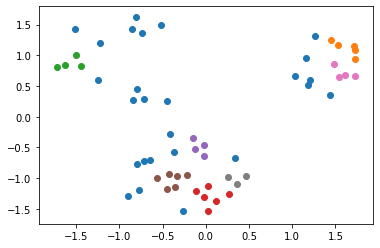

TypeError: '<' not supported between instances of 'NoneType' and 'float'

In [132]:
###############################
# Training step               #
###############################

DBSCAN_plot_multiple_parameters(training_set, 4, 20, 5, get_distance, dim, False)

###############################
# Validation step             #
###############################

# first approach
#print("\n\033[1mFisrt approach:\033[0m run DBSCAN for the test set with the most convenient configuration obtained from the training step.")
model = []
clusters_1 = {}
testset_labeled, clusters_1 = DBSCAN(test_set, get_distance, 2, best_e, best_d)
DBSCAN_plot_2D_clusters(clusters_1)
del clusters_1[0]
DBSCAN_plot_silhouette_graph(test_set, clusters_1, 2, best_e)

In [ ]:

#DBSCAN_plot_multiple_parameters(training_set, 4, 20, 5, get_distance, 2, True)

# Run DBSCAN over the dataset using different values of minimum density and distance
def DBSCAN_plot_multiple_parameters(dataset, minDensity, maxDensity, step, func_dist, dim, plot=True):
    for density in range(minDensity, maxDensity+1, step):
        
        print(color.BOLD)
        print("-------------------------------------------------------------------------------------")
        print("Elbow graph with k = ", density)
        print(color.END)
        DBSCAN_plot_elbow_graph(dataset, func_dist, dim, density)
        
        for eps in range(density, 0, -1):
            model = []
            clusters = {}
            model, clusters = DBSCAN(dataset, func_dist, dim, eps/density, density)
            print("---------------------------------------------------------------------------------")
            print("\033[1mConfiguration:\033[0m minDensity = ", density, ", eps = ", eps/density)
            print("There are", len(clusters)-1, "clusters and", len(clusters[0]), "outliers.")
            if len(clusters[0]) <= 0:
                del clusters[0]
            
            if (plot): 
                DBSCAN_plot_2D_clusters(clusters)
                
            DBSCAN_plot_silhouette_graph(training_set, clusters, 2, eps/density)